<a href="https://colab.research.google.com/github/jamesBaker361/colab/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

first we import all of our libraries

In [0]:
# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tF
import torchvision.models as models

# visualization tools
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

# misc
import numpy as np
import os
import copy
from urllib.request import urlretrieve
from google.colab import files

we specify the image size (512 arbitrarily chosen i guess) and what device to use

In [0]:
# specify whether pytorch uses cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512

now we got 3 images to help us deal with images

In [0]:
# reads image from disk and casts it to a tensor
def imload(image_name, imsize):
    image = Image.open(image_name)        # read the image into an array
    image = tF.resize(image, imsize)      # resize the image and casts it to a tensor
    image = tF.center_crop(image, imsize) # center crop to size
    image = tF.to_tensor(image)           # cast PIL image to pytorch tensor
    image = image.float()                 # cast to float tensor
    image = image.unsqueeze(0)            # insert dummy batch dimension needed to fit into the model
    
    return image
  
# unload a tensor into a PIL image
imunload = torchvision.transforms.ToPILImage()

# displays an image from a tensor
def imshow(tensor, title=None):
    image = tensor.cpu().clone() # clone the tensor to not do changes on it
    image = image.squeeze(0)     # remove the fake batch dimension
    image = imunload(image)      # unload the image into PIL
    
    # matplotlib: show the image
    plt.imshow(image)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.show()
    return

now we make a gram matrix whatever that is

In [0]:
# get gram matrix of feature block
def gram_matrix(x):
    # flatten spatial features
    bs, nfeats, h, w = x.size()
    x = x.view(bs*nfeats, h*w)
    
    # compute gram product by matrix multiplication and normalize
    G = torch.mm(x, x.t())
    G.div(bs*nfeats*h*w)
    return G

now we gotta make a vgg for feature extraction

In [0]:
# default vgg normalization values
vgg_norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
vgg_norm_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

# extract features from input at layers of interest
class VGGFeatureExtractor(nn.Module):
    
    # given a vgg model, makes a copy of the vgg with only the
    # layers required to extract features at layers of interest;
    def __init__(self, vgg, layers_of_interest):
        super(VGGFeatureExtractor, self).__init__()
        
        # remember layers of interest
        self.layers_of_interest = layers_of_interest
        
        # copy vgg into a list
        # keep only up to the max layer of interest
        self.layer_list = []
        for i in range(max(layers_of_interest)+1):
            
            # replace relu layers with not in-place relu layers
            if isinstance(vgg[i], nn.ReLU):
                self.layer_list.append(nn.ReLU(inplace=False))
            
            # otherwise, just append a copy of the layer
            else:
                self.layer_list.append(copy.deepcopy(vgg[i]))
        
        # layer_list should now be just the subset of vgg
        # you need to extract features at layers of interest
        return
    
    # feed the input through the layers, remembering
    # the outputs of layers of interest
    def forward(self, x):
        
        # normalize the input
        x = (x - vgg_norm_mean.to(x.device)) / vgg_norm_std.to(x.device)
        
        # feed the input through layer by layer, while keeping
        # a list of features extracted at layers of interest
        extracted_features = {}
        for i in range(max(self.layers_of_interest)+1):
            
            # apply the layer to the previous output
            layer = self.layer_list[i]
            x = layer(x)
            
            # remember the output if the layer was of interest
            if i in self.layers_of_interest:
                extracted_features[i] = x
        
        # extracted_features should now have all features of interest
        return extracted_features

now we get that vgg from the premade one thanks google

In [0]:
# get a copy of the pretrained vgg image classification model
vgg = models.vgg19(pretrained=True).features.to(device).eval()
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:10, 55305015.31it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

arbitrarily choose some layers to use

In [0]:
# we will select the following layers to use
content_layers = set([7])
style_layers = set([0,2,5,7,10])

we only use some parts of the vgg

In [0]:
# construct network, set it to evaluation mode
model = VGGFeatureExtractor(
    vgg,
    layers_of_interest=set.union(content_layers, style_layers),
).to(device).eval()

# vgg is no longer needed
del vgg

In [0]:
for m in model.layer_list:
  print(m)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


now we download some images and save them

In [0]:
# default pytorch tutorial suggestions
_ = urlretrieve(
    'http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg',
    'picasso.jpg')
_ = urlretrieve(
    'http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg',
    'dancing.jpg')

# starry night
_ = urlretrieve(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
    'starry.jpg')

# old queen's gate
_ = urlretrieve(
    'https://c1.staticflickr.com/1/30/95045744_5f58de1fc0_b.jpg',
    'queens.jpg')

# masters of busch campus
_ = urlretrieve(
    'https://download.ams.birds.cornell.edu/api/v1/asset/59953191/1800',
    'geese.jpg')

# beloved rutgers honors college
_ = urlretrieve(
    'http://devco.org/download/images/side-carousel/honors/HC1_overlay-x2.jpg',
    'hc.jpg')

now we load all of our images

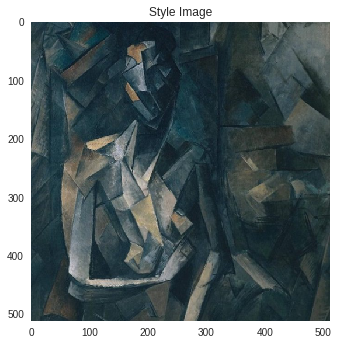

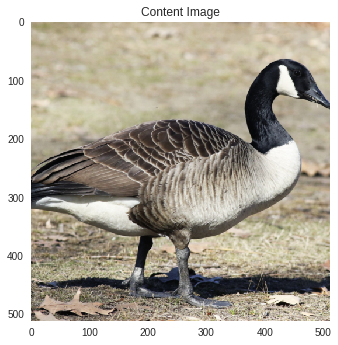

In [0]:
# load images into this notebook
style_img = imload("./picasso.jpg", imsize).to(device)
content_img = imload("./geese.jpg", imsize).to(device)

# display images
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

now we get the features for style

In [0]:
# get features for style image
# convert features into gram matrices
style_features = model(style_img)
for i in style_features:
    style_features[i] = gram_matrix(style_features[i])
style_features = {i:style_features[i].detach() for i in style_features}

now we get features for the content image (honk)

In [0]:
# get features for content image
content_features = model(content_img)
content_features = {i:content_features[i].detach() for i in content_features}

now we make x, which starts out as a copy of content, but its actually what we're optimizing to make a nice style trasnferred clone

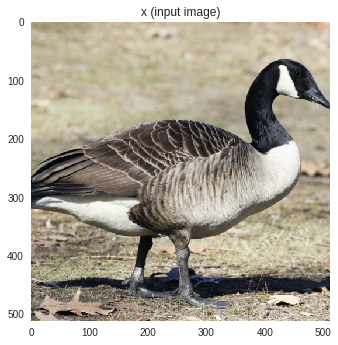

<class 'torch.Tensor'>


In [0]:
# create input image x, a copy of content image
x = content_img.clone()
imshow(x, title='x (input image)')
# set x so that it takes gradient updates
x.requires_grad_()

# create optimizer for x
optimizer = optim.LBFGS([x])
print(type(x))

some hyperparamters we oughta set

In [0]:
# set loss weights
content_weight = 1
style_weight = 100000

# set number of steps
# 16 steps take around 60s
steps = 16

now we actually do the thing

In [0]:
def transfer():
  # apply style for many steps
  for n in range(steps):

      # fancy gradient update procedure for lbfgs
      def closure():
          # clear gradients
          optimizer.zero_grad()

          # get features of x
          x_features = model(x)

          # calculate content loss
          content_loss = 0
          for i in content_layers:
              content_loss += F.mse_loss(
                  x_features[i],
                  content_features[i],
              )

          # calculate style loss
          style_loss = 0
          for i in style_layers:
              style_loss += F.mse_loss(
                  gram_matrix(x_features[i]),
                  style_features[i],
              )

          # calculate total loss, and backpropagate
          loss = content_loss*content_weight + style_loss*style_weight
          loss.backward(retain_graph=True)

          # return loss
          return loss
      optimizer.step(closure)

      # clamp image values
      x.data.clamp_(0,1)

      # print updates
      if n%1==0:
          print('step: %d / %d'%(n,steps))

  # print completion
  print('%d steps complete'%steps)
  return(x)
x=transfer()

step: 0 / 16
step: 1 / 16
step: 2 / 16
step: 3 / 16
step: 4 / 16
step: 5 / 16
step: 6 / 16
step: 7 / 16
step: 8 / 16
step: 9 / 16
step: 10 / 16
step: 11 / 16
step: 12 / 16
step: 13 / 16
step: 14 / 16
step: 15 / 16
16 steps complete


lets see what the outcome was

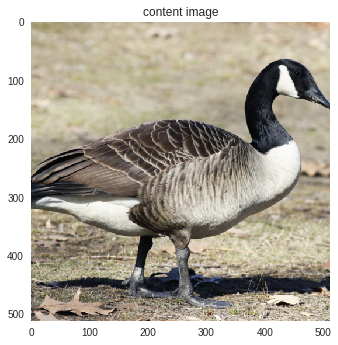

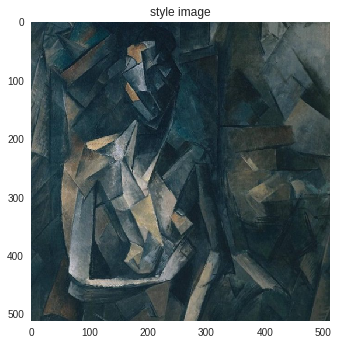

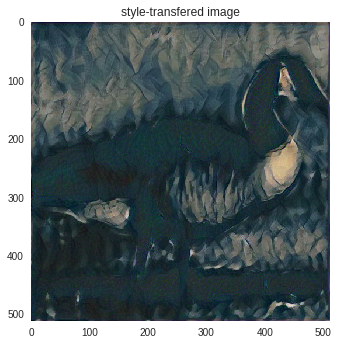

In [0]:
# display results
imshow(content_img, title='content image')
imshow(style_img, title='style image')
imshow(x, title='style-transfered image')

we're going to replace transfer with a reusable version

In [0]:
def transferBetter(content_img):
  content_features = model(content_img)
  content_features = {i:content_features[i].detach() for i in content_features}
  x = content_img.clone()
  x.requires_grad_()
  #print(type(x))
  optimizer = optim.LBFGS([x])
  # apply style for many steps
  for n in range(steps):

      # fancy gradient update procedure for lbfgs
      def closure():
          # clear gradients
          optimizer.zero_grad()

          # get features of x
          #print("steps = "+str(steps))
          #print(type(x))
          x_features = model(x)

          # calculate content loss
          content_loss = 0
          for i in content_layers:
              content_loss += F.mse_loss(
                  x_features[i],
                  content_features[i],
              )

          # calculate style loss
          style_loss = 0
          for i in style_layers:
              style_loss += F.mse_loss(
                  gram_matrix(x_features[i]),
                  style_features[i],
              )

          # calculate total loss, and backpropagate
          loss = content_loss*content_weight + style_loss*style_weight
          loss.backward(retain_graph=True)

          # return loss
          return loss
      optimizer.step(closure)

      # clamp image values
      x.data.clamp_(0,1)

      # print updates
      if n%1==0:
          print('step: %d / %d'%(n,steps))

  # print completion
  print('%d steps complete'%steps)
  return(x)

now we gotta import something real quick

In [0]:
from urllib.request import urlopen

make a helper function to turn a list of urls into a list of content images

<class 'torch.Tensor'>
<class 'torch.Tensor'>


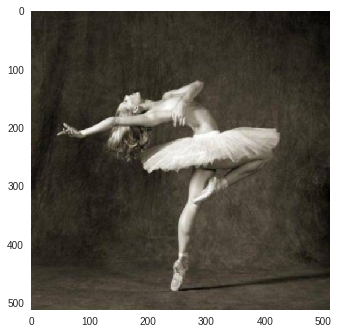

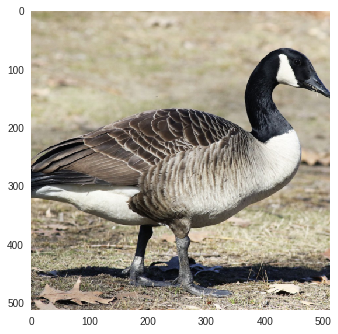

In [0]:

def urlsToContent(urls):
  cont=[]
  for u in urls:
    _ = urlretrieve(u,'img.jpg')
    cont.append(imload("./img.jpg", imsize).to(device))
    print(type(cont[len(cont)-1]))
  return(cont)

contents=['http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg','https://download.ams.birds.cornell.edu/api/v1/asset/59953191/1200']
imtens=urlsToContent(contents)
for u in imtens:
  imshow(u)

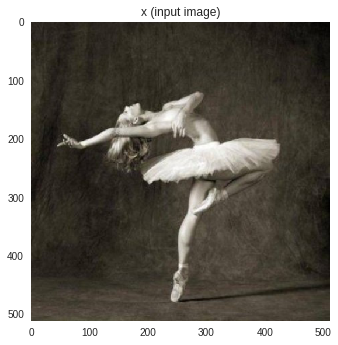

step: 0 / 16
step: 1 / 16
step: 2 / 16
step: 3 / 16
step: 4 / 16
step: 5 / 16
step: 6 / 16
step: 7 / 16
step: 8 / 16
step: 9 / 16
step: 10 / 16
step: 11 / 16
step: 12 / 16
step: 13 / 16
step: 14 / 16
step: 15 / 16
16 steps complete


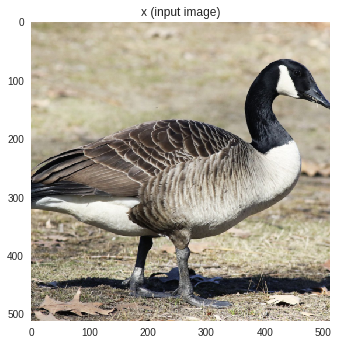

step: 0 / 16
step: 1 / 16
step: 2 / 16
step: 3 / 16
step: 4 / 16
step: 5 / 16
step: 6 / 16
step: 7 / 16
step: 8 / 16
step: 9 / 16
step: 10 / 16
step: 11 / 16
step: 12 / 16
step: 13 / 16
step: 14 / 16
step: 15 / 16
16 steps complete


In [0]:
style=[]
for c in imtens:
  content_img=c
  content_features = model(content_img)
  content_features = {i:content_features[i].detach() for i in content_features}
  x = content_img.clone()
  imshow(x, title='x (input image)')
  # set x so that it takes gradient updates
  x.requires_grad_()
  optimizer = optim.LBFGS([x])
  style.append(transfer())
  


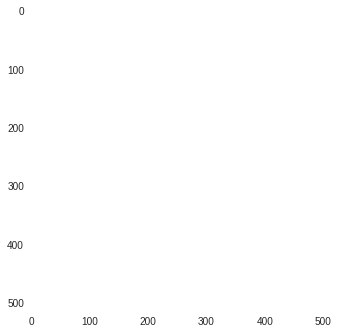

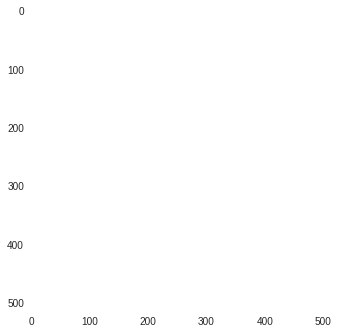

In [0]:
for s in style:
  imshow(s)